In [7]:
from os import environ

environ['optimizer'] = 'Adam'
environ['num_workers']= '2'
environ['batch_size']= str(2048)
environ['n_epochs']= '1000'
environ['batch_norm']= 'True'
environ['loss_func']='MAPE'
environ['layers'] = '600 350 200 180'
environ['dropouts'] = '0.1 '* 4
environ['lr'] = '1e-03'
environ['log'] = 'False'
environ['weight_decay'] = '0.01'
environ['cuda_device'] ='cuda:4'
environ['dataset'] = 'data/speedup_dataset2.pkl'

%run utils.ipynb

In [8]:
train_dl, val_dl, test_dl = train_dev_split(dataset, batch_size, num_workers, log=log)

db = fai.basic_data.DataBunch(train_dl, val_dl, test_dl, device=device)

function329_schedule_13
0
{'computations': {'computations_array': [{'comp_id': 1,
                                          'lhs_data_type': 'p_int32',
                                          'loop_iterators_ids': [2, 3],
                                          'operations_histogram': [[5, 3, 0, 0],
                                                                   [0, 0, 0, 0],
                                                                   [0, 0, 0, 0],
                                                                   [0, 0, 0, 0],
                                                                   [0, 0, 0, 0],
                                                                   [0, 0, 0, 0],
                                                                   [0,
                                                                    0,
                                                                    0,
                                                                    0]],
    

NameError: name 'exit' is not defined

In [3]:
input_size = train_dl.dataset.X.shape[1]
output_size = train_dl.dataset.Y.shape[1]


model = None 

if batch_norm:
    model = Model_BN(input_size, output_size, hidden_sizes=layers_sizes, drops=drops)
else:
    model = Model(input_size, output_size)
    
if loss_func == 'MSE':
    criterion = nn.MSELoss()
elif loss_func == 'MAPE':
    criterion = mape_criterion
elif loss_func == 'SMAPE':
    criterion = smape_criterion

l = fai.Learner(db, model, loss_func=criterion, metrics=[mape_criterion, rmse_criterion])

if optimizer == 'SGD':
    l.opt_func = optim.SGD

In [4]:
l = l.load(f"r_speedup_{optimizer}_batch_norm_{batch_norm}_{loss_func}_nlayers_{len(layers_sizes)}_log_{log}")

In [125]:
l.lr_find()
l.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [4]:
l.fit_one_cycle(int(environ['n_epochs']), float(environ['lr']))

epoch,train_loss,valid_loss,mape_criterion,rmse_criterion
1,93.423729,92.886703,92.886703,2.151367
2,90.008125,90.564941,90.564941,2.121669
3,87.441612,90.928154,90.928154,2.121073
4,85.988487,82.488853,82.488853,2.109176
5,84.849869,84.743462,84.743462,2.109800
6,84.042099,80.569115,80.569115,2.104256
7,83.058922,78.487328,78.487328,2.091212
8,81.217255,76.329285,76.329285,2.075416
9,79.180939,78.379677,78.379677,2.050333
10,77.059280,71.022118,71.022118,2.021203


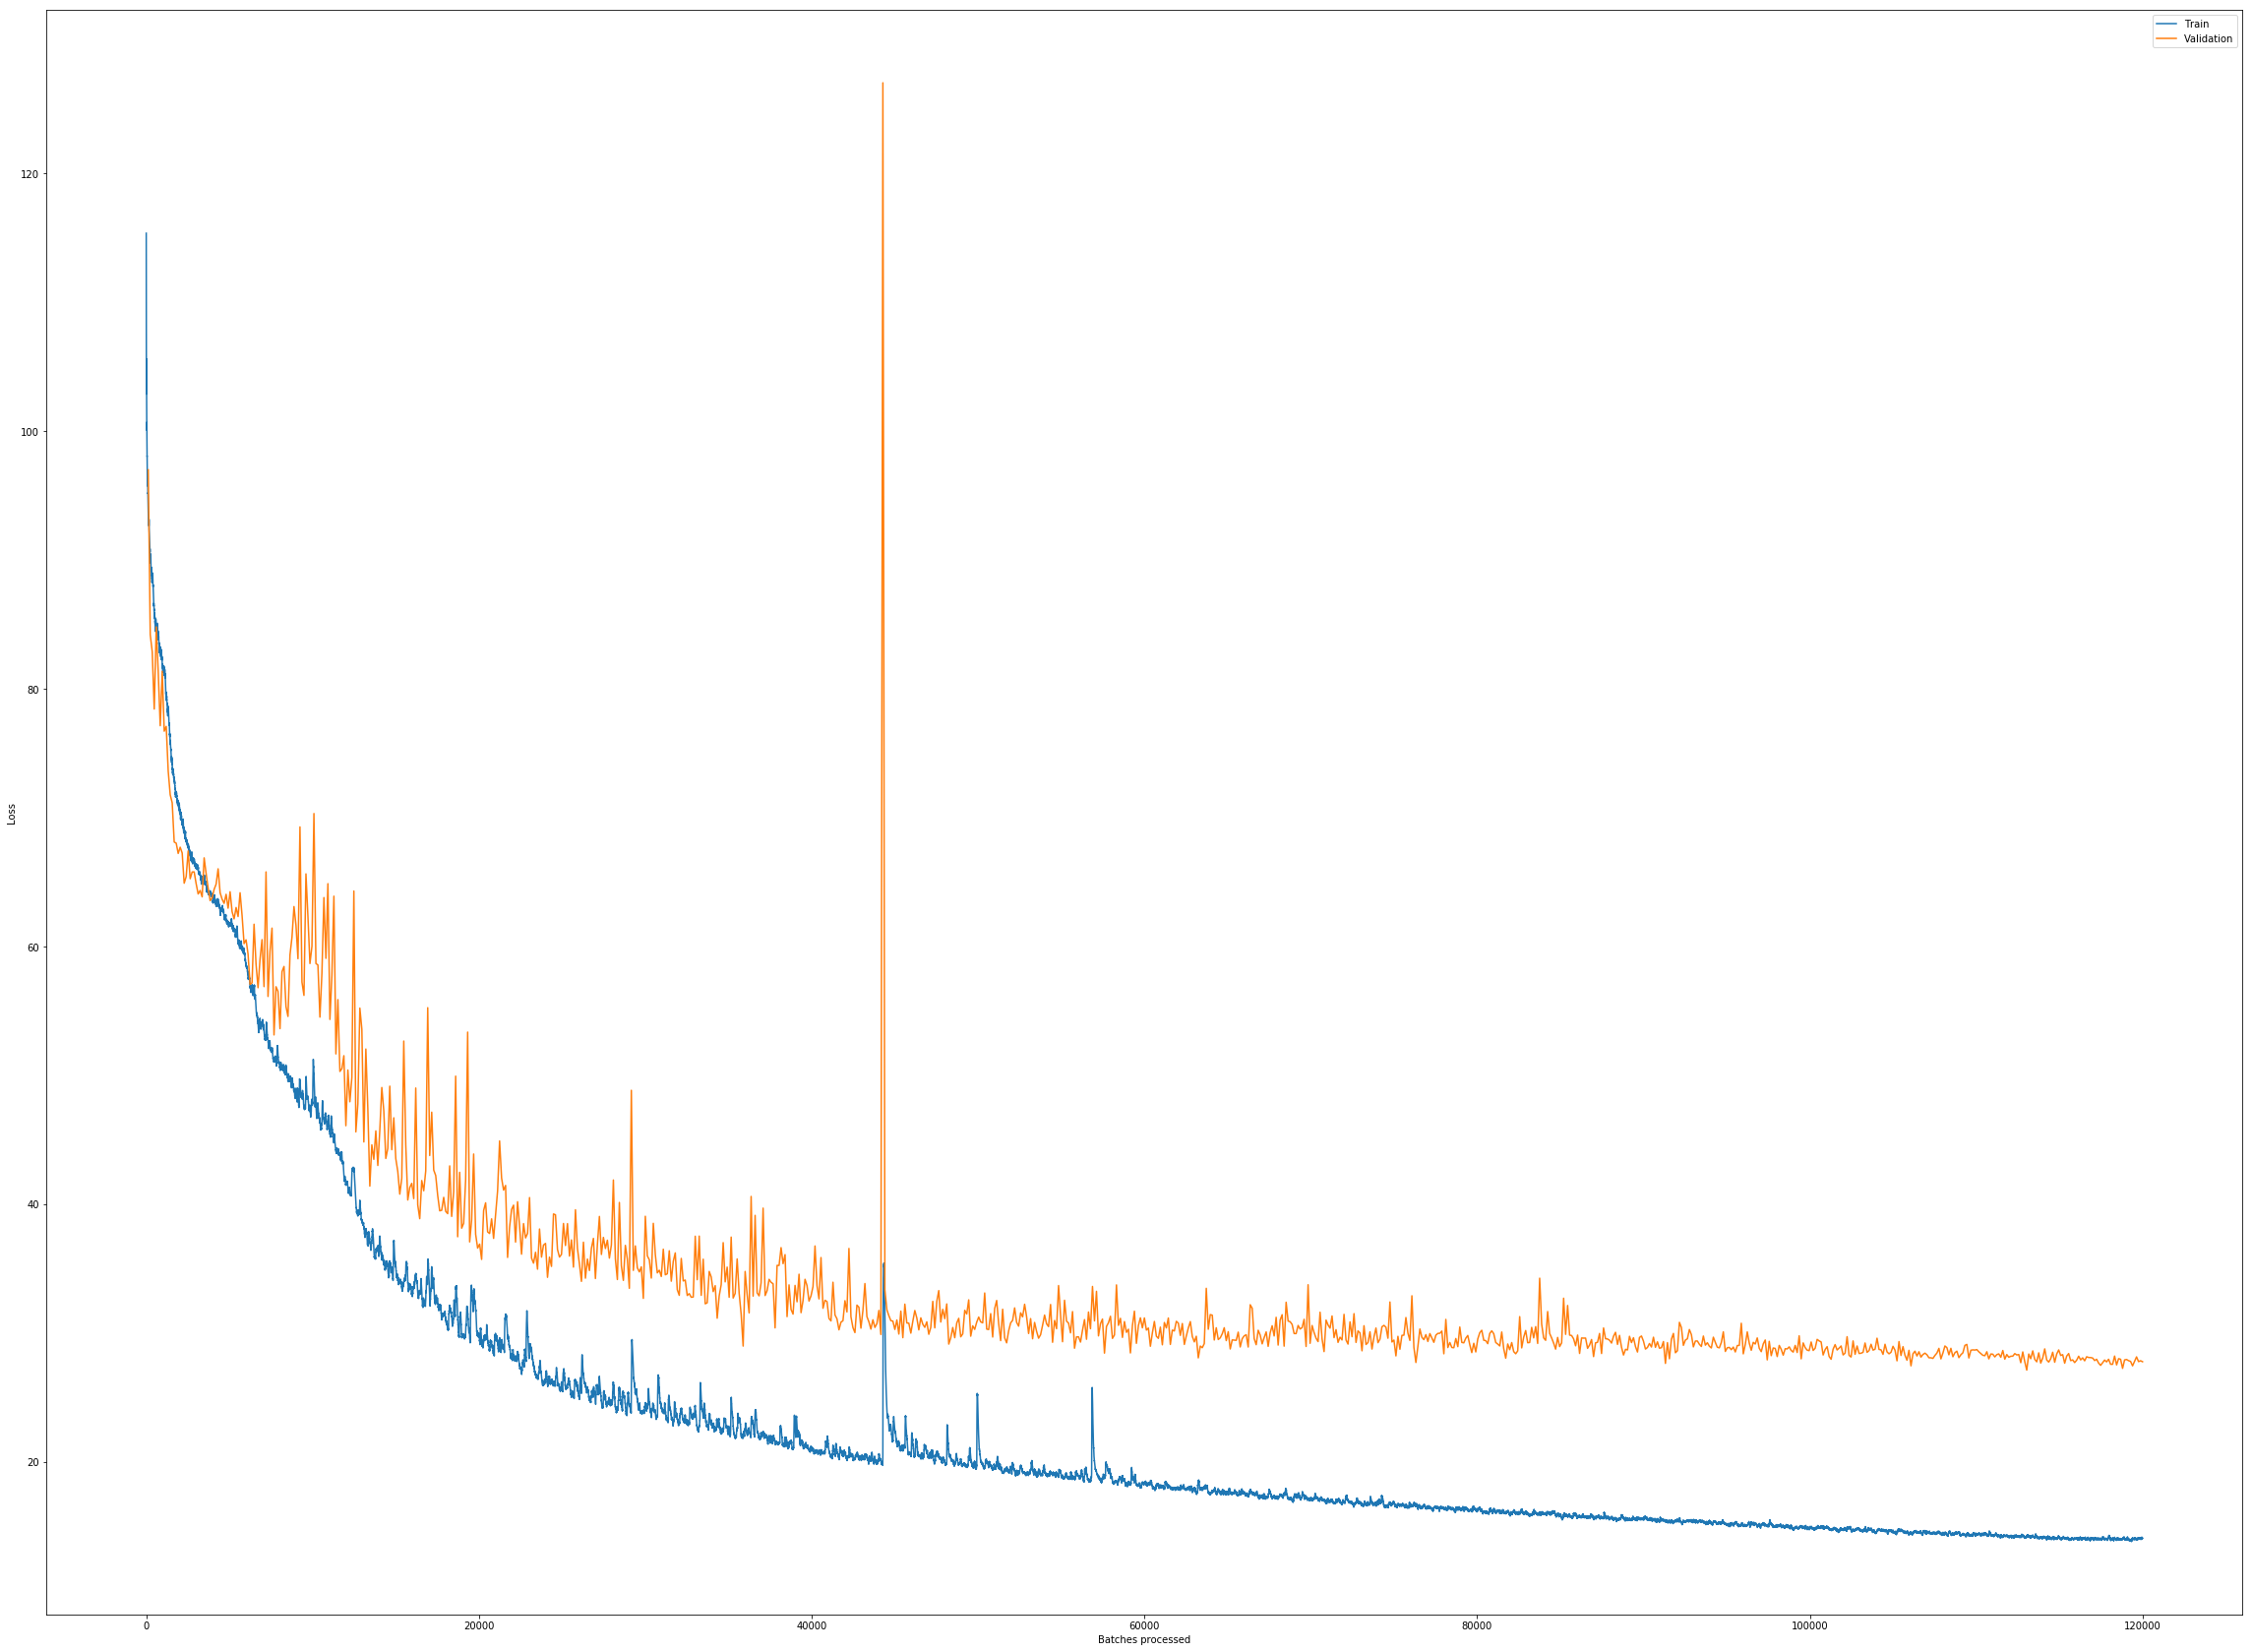

In [12]:
l.recorder.plot_losses()

In [6]:
l.save(f"r_speedup_{optimizer}_batch_norm_{batch_norm}_{loss_func}_nlayers_{len(layers_sizes)}_log_{log}")

In [7]:
!ls models

old_models
old_repr
r_speedup_Adam_batch_norm_True_MAPE_nlayers_5_log_False.pth
speedup_Adam_batch_norm_True_MAPE_nlayers_5_log_False2.pth
speedup_Adam_batch_norm_True_MAPE_nlayers_5_log_False.pth
speedup_Adam_batch_norm_True_MSE_nlayers_5_log_False.pth
speedup_Adam_batch_norm_True_MSE_nlayers_5_log_True.pth
tmp.pth


In [28]:
val_df = get_results_df(val_dl, l.model)
train_df = get_results_df(train_dl, l.model)

In [29]:
df = train_df


In [30]:
df[:][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,245283.000000,245283.000000,245283.000000,245283.000000
mean,1.037621,1.135724,0.152116,12.830106
std,1.231515,1.405682,0.464680,28.543703
min,0.010180,0.008491,0.000000,0.000000
25%,0.264881,0.278690,0.002987,0.895514
50%,0.844768,0.899071,0.023104,5.397871
75%,0.998950,1.036481,0.100247,13.001473
max,9.480000,16.089287,15.559452,848.957703


In [31]:
df = val_df

In [32]:
df[:][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.121260,1.430897,0.390623,27.763691
std,1.156423,1.683147,0.679037,41.883354
min,0.018547,0.014795,0.000046,0.007319
25%,0.377303,0.395193,0.011900,3.115584
50%,0.993079,1.000000,0.113269,20.872551
75%,1.165657,1.621683,0.391169,43.921596
max,7.675441,10.872228,4.920828,844.224915


In [33]:
df[(df.interchange==0) & (df.unroll == 0) & (df.tile == 0)][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,2074.000000,2074.0,2074.000000,2074.000000
mean,0.985529,1.0,0.017589,1.758861
std,0.111946,0.0,0.111498,11.149847
min,0.071318,1.0,0.000073,0.007319
25%,0.997701,1.0,0.001470,0.147021
50%,0.998260,1.0,0.001813,0.181329
75%,0.998590,1.0,0.002428,0.242829
max,1.891778,1.0,0.928682,92.868195


In [44]:
df[(df.interchange==0) & (df.unroll == 0) & (df.tile == 1)][['index','name','prediction','target', 'abs_diff','APE']].to_csv(path_or_buf='./eval_results.csv',sep=';')
df[(df.interchange==0) & (df.unroll == 0) & (df.tile == 1)][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,725.000000,725.000000,725.000000,725.000000
mean,1.301574,1.519225,0.354056,23.900990
std,1.112958,1.422773,0.483243,19.511810
min,0.158533,0.091200,0.000204,0.020753
25%,0.432121,0.508859,0.065178,8.419112
50%,0.975921,0.993141,0.172049,18.377670
75%,1.975362,2.207209,0.414999,34.993168
max,7.673403,9.358214,3.923676,126.306580


In [35]:
df[(df.interchange==0) & (df.unroll == 1) & (df.tile == 0)][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,281.000000,281.000000,281.000000,281.000000
mean,4.309521,6.044158,1.815515,61.342331
std,2.116049,3.221366,1.237432,163.233612
min,0.979377,0.105179,0.000852,0.086115
25%,2.074235,2.546717,0.614721,16.486435
50%,5.464447,7.389543,1.802265,28.025612
75%,5.544522,8.668690,2.898372,38.227890
max,7.327499,10.872228,4.777884,844.224915


In [36]:
df[(df.interchange==1) & (df.unroll == 0) & (df.tile == 0)][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,232.000000,232.000000,232.000000,232.000000
mean,0.756619,0.918692,0.222288,21.729357
std,0.914184,1.168210,0.461534,20.075941
min,0.020958,0.018092,0.000089,0.079193
25%,0.238594,0.265846,0.022004,6.248699
50%,0.396349,0.466655,0.070740,16.291368
75%,0.876001,0.956079,0.203351,28.746875
max,4.947685,8.069739,3.122054,112.560829


In [37]:
df[(df.interchange==0) & (df.unroll == 1) & (df.tile == 1)][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,868.000000,868.000000,868.000000,868.000000
mean,1.373762,1.748770,0.477148,31.763561
std,1.171251,1.605983,0.570058,44.691597
min,0.164368,0.057130,0.000118,0.045584
25%,0.428907,0.695116,0.085793,9.017995
50%,1.032962,1.241629,0.282237,26.219162
75%,2.054201,2.229650,0.713841,44.385671
max,7.675441,10.137201,4.077254,401.347290


In [38]:
df[(df.interchange==1) & (df.unroll == 1) & (df.tile == 0)][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,1276.000000,1276.000000,1276.000000,1276.000000
mean,2.012736,2.878316,0.996945,31.574406
std,1.366116,2.108479,1.017374,21.246101
min,0.033753,0.042484,0.000265,0.022992
25%,0.717553,0.977715,0.163885,11.196567
50%,2.116860,2.629361,0.559276,29.473694
75%,2.658386,4.365878,1.821425,49.913550
max,4.868882,9.784180,4.920828,132.563797


In [39]:
df[(df.interchange==1) & (df.unroll == 0) & (df.tile == 1)][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,1663.000000,1663.000000,1663.000000,1663.000000
mean,0.759392,0.937209,0.260730,28.067686
std,0.769510,1.023356,0.399831,20.749691
min,0.018548,0.014836,0.000046,0.061909
25%,0.210683,0.246893,0.039022,10.700531
50%,0.494625,0.624512,0.122702,24.871428
75%,1.030154,1.173670,0.315577,43.254141
max,4.934253,8.724252,3.983392,139.318390


In [40]:
df[(df.interchange==1) & (df.unroll == 1) & (df.tile == 1)][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,2881.000000,2881.000000,2881.000000,2881.000000
mean,0.629967,0.858291,0.323311,41.598583
std,0.725950,1.094979,0.488463,37.766975
min,0.018547,0.014795,0.000056,0.023296
25%,0.158124,0.183774,0.055104,19.515968
50%,0.401537,0.424563,0.149758,38.063084
75%,0.849428,1.033311,0.366112,53.976719
max,4.855897,9.207530,4.390360,447.704224


In [41]:
df[(df.interchange + df.tile + df.unroll != 0)][['prediction','target', 'abs_diff','APE']].describe()

,prediction,target,abs_diff,APE
count,7926.000000,7926.000000,7926.000000,7926.000000
mean,1.156775,1.543651,0.488235,34.568348
std,1.295356,1.874331,0.729769,44.243641
min,0.018547,0.014795,0.000046,0.020753
25%,0.289361,0.312547,0.060371,12.950603
50%,0.676460,0.830516,0.194361,28.857708
75%,1.662223,2.132191,0.514185,48.964257
max,7.675441,10.872228,4.920828,844.224915


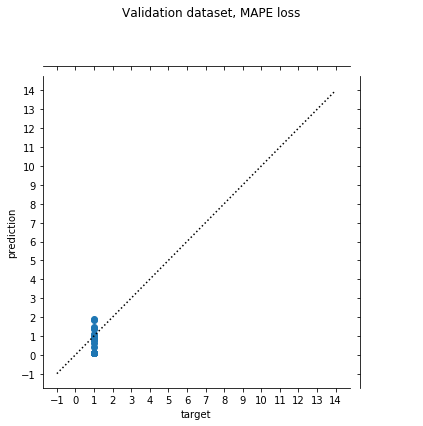

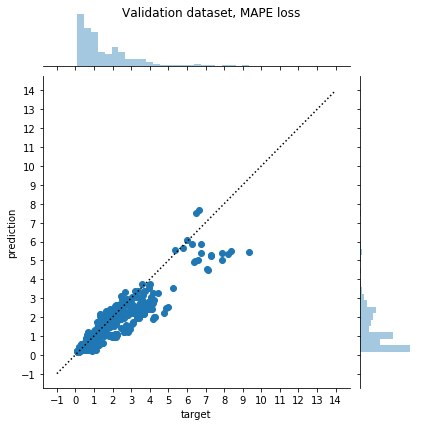

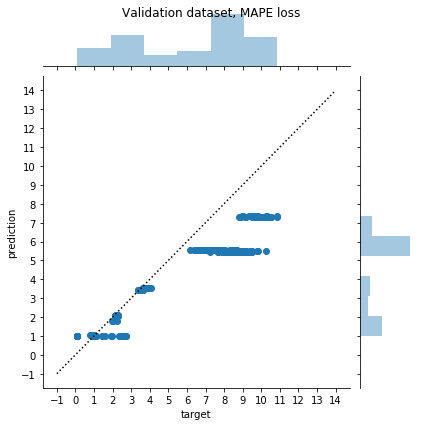

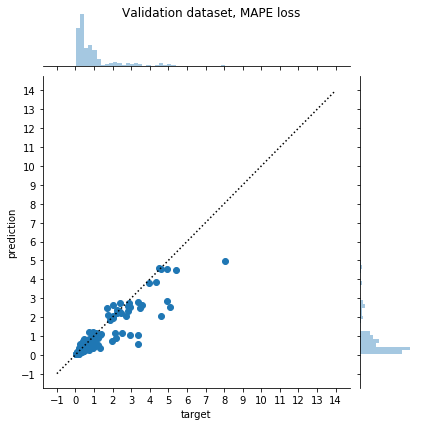

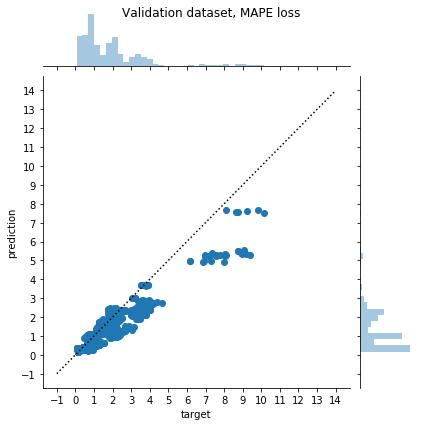

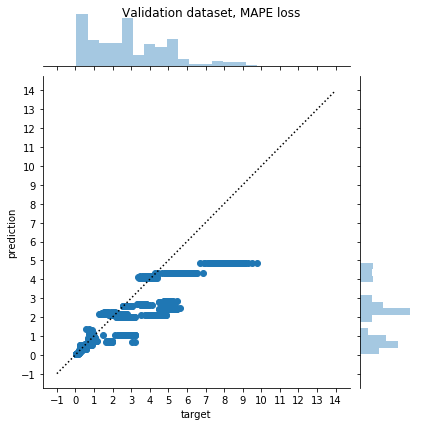

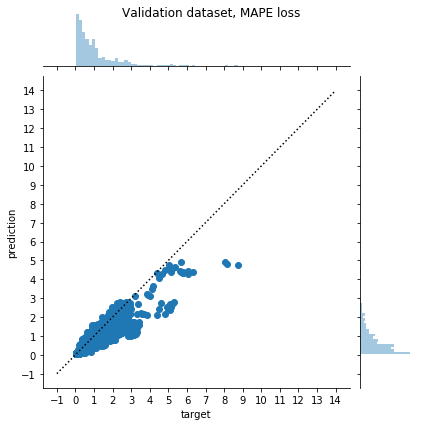

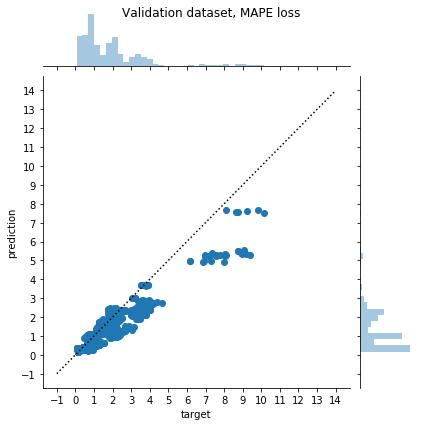

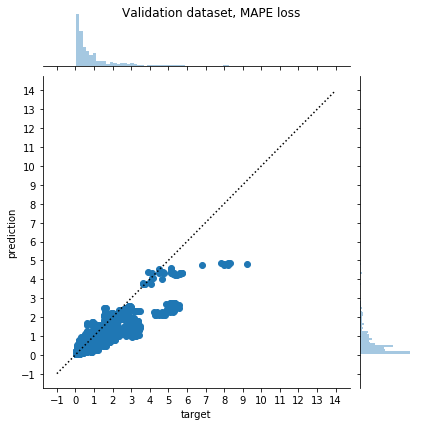

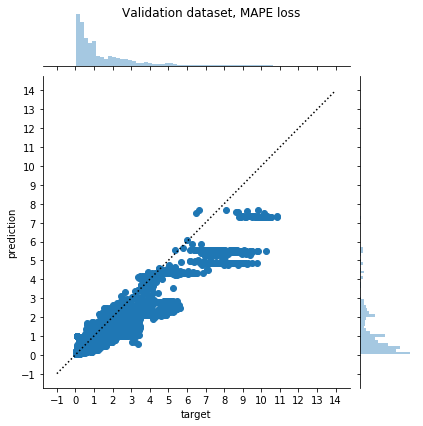

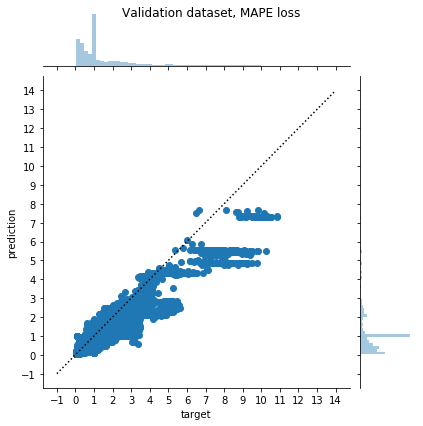

In [42]:
df1 = df[(df.interchange==0) & (df.unroll == 0) & (df.tile == 0)]
joint_plot(df1, f"Validation dataset, {loss_func} loss")
df1 = df[(df.interchange==0) & (df.unroll == 0) & (df.tile == 1)]
joint_plot(df1, f"Validation dataset, {loss_func} loss")
df1 = df[(df.interchange==0) & (df.unroll == 1) & (df.tile == 0)]
joint_plot(df1, f"Validation dataset, {loss_func} loss")
df1 = df[(df.interchange==1) & (df.unroll == 0) & (df.tile == 0)]
joint_plot(df1, f"Validation dataset, {loss_func} loss")
df1 = df[(df.interchange==0) & (df.unroll == 1) & (df.tile == 1)]
joint_plot(df1, f"Validation dataset, {loss_func} loss")
df1 = df[(df.interchange==1) & (df.unroll == 1) & (df.tile == 0)]
joint_plot(df1, f"Validation dataset, {loss_func} loss")
df1 = df[(df.interchange==1) & (df.unroll == 0) & (df.tile == 1)]
joint_plot(df1, f"Validation dataset, {loss_func} loss")
df1 = df[(df.interchange==0) & (df.unroll == 1) & (df.tile == 1)]
joint_plot(df1, f"Validation dataset, {loss_func} loss")
df1 = df[(df.interchange==1) & (df.unroll == 1) & (df.tile == 1)]
joint_plot(df1, f"Validation dataset, {loss_func} loss")
df1 = df[(df.interchange + df.tile + df.unroll != 0)]
joint_plot(df1, f"Validation dataset, {loss_func} loss")
df2 = df
joint_plot(df2, f"Validation dataset, {loss_func} loss")